In [ ]:
from __future__ import print_function

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
# $example on$
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

TRAINING ON HISTORICAL DATA:

In [35]:
if __name__ == "__main__":
    spark = SparkSession \
        .builder \
        .appName("Stoxx") \
        .getOrCreate()

In [40]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# load data
df = spark.read.csv("combined_data.csv", header=True, inferSchema=True)

# preprocess data
df = df.withColumn("timestamp", to_date(col("timestamp"), "yyyy-MM-dd")) # convert timestamp to date
df = df.drop("dividend_amount", "split_coefficient", "ticker") # remove unnecessary columns

# engineer features
df = df.withColumn("daily_return", (col("adjusted_close") - lag("adjusted_close", 1).over(Window.orderBy("timestamp")))/lag("adjusted_close", 1).over(Window.orderBy("timestamp"))) # calculate daily return
df = df.withColumn("price_range", col("high") - col("low"))
df = df.withColumn("prev_close", lag("adjusted_close", 1).over(Window.orderBy("timestamp"))) # add previous day's adjusted close price
df = df.na.drop() # remove rows with missing values

# create feature vector
assembler = VectorAssembler(inputCols=["open", "high", "low", "prev_close", "daily_return", "price_range"], outputCol="features")
df = assembler.transform(df)

# split data into train and test sets
train, test = df.randomSplit([0.8, 0.2], seed=42)

# train linear regression model
lr = LinearRegression(featuresCol="features", labelCol="close", maxIter=5, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train)

# make predictions on test set
predictions = model.transform(test)

# evaluate model performance
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("*****************************************************************************")
print(f"Root Mean Squared Error (RMSE): {rmse}")



23/05/12 22:03:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:03:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:03:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:03:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:03:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:03:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 2

23/05/12 10:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 10:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 10:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 10:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 10:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 10:39:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 1

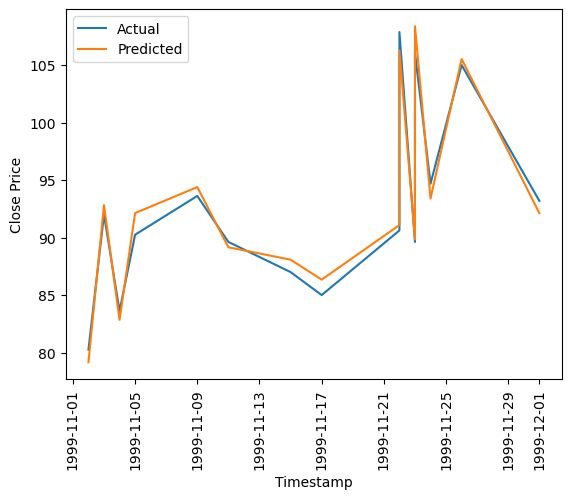

In [9]:
import matplotlib.pyplot as plt

# extract actual and predicted labels from test set
actuals = predictions.select("timestamp", "close").collect()
predicted = predictions.select("timestamp", "prediction").collect()

# create lists of timestamps, actual labels, and predicted labels
timestamps = [row.timestamp for row in actuals[:15]]
actual_labels = [row.close for row in actuals[:15]]
predicted_labels = [row.prediction for row in predicted[:15]]

# plot curve between actual and predicted labels
plt.plot(timestamps, actual_labels, label="Actual")
plt.plot(timestamps, predicted_labels, label="Predicted")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [23]:
test_df = spark.read.csv("/Users/rajoza/Downloads/output.csv", header=True, inferSchema=True)
test_df_=test_df.limit(20)
test_df.show()


+-------------------+-------+--------+--------+-------+----------------+---------+---------------+-----------------+
|          timestamp|   open|    high|     low|  close|  adjusted_close|   volume|dividend_amount|split_coefficient|
+-------------------+-------+--------+--------+-------+----------------+---------+---------------+-----------------+
|2023-05-12 00:00:00| 173.62|  174.06|   171.0| 172.57|          172.57| 45350690|           0.24|              1.0|
|2023-05-11 00:00:00| 173.85|  174.59|  172.17| 173.75|173.508694519993| 49514676|            0.0|              1.0|
|2023-05-10 00:00:00| 173.02|  174.03|   171.9|173.555|173.313965337654| 53724501|            0.0|              1.0|
|2023-05-09 00:00:00| 173.05|  173.54|   171.6| 171.77|171.531444360859| 45326874|            0.0|              1.0|
|2023-05-08 00:00:00| 172.48|  173.85|  172.11|  173.5|173.259041722123| 55962793|            0.0|              1.0|
|2023-05-05 00:00:00|170.975|   174.3|  170.76| 173.57|173.32894

TESTING ON UNSEEN STREAMING DATA

In [63]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# load data
test_df = spark.read.csv("/Users/rajoza/Downloads/output.csv", header=True, inferSchema=True)
test_df=test_df.orderBy(desc("timestamp"))
test_df=test_df.limit(20)

# preprocess data
test_df = test_df.withColumn("timestamp", to_date(col("timestamp"), "yyyy-MM-dd")) # convert timestamp to date
test_df = test_df.drop("dividend_amount", "split_coefficient", "ticker") # remove unnecessary columns

# engineer features
test_df = test_df.withColumn("daily_return", (col("adjusted_close") - lag("adjusted_close", 1).over(Window.orderBy("timestamp")))/lag("adjusted_close", 1).over(Window.orderBy("timestamp"))) # calculate daily return
test_df = test_df.withColumn("price_range", col("high") - col("low"))
test_df = test_df.withColumn("prev_close", lag("adjusted_close", 1).over(Window.orderBy("timestamp"))) # add previous day's adjusted close price
test_df = test_df.na.drop() # remove rows with missing values

# create feature vector
assembler = VectorAssembler(inputCols=["open", "high", "low", "prev_close", "daily_return", "price_range"], outputCol="features")
test_df = assembler.transform(test_df)


# split data into train and test sets
#train, test = df.randomSplit([0.8, 0.2], seed=42)

# train linear regression model


# make predictions on test set
predictions2 = model.transform(test_df)

# evaluate model performance
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions2)
print("*****************************************************************************")
print(f"Root Mean Squared Error (RMSE): {rmse}")


23/05/12 22:30:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:30:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:30:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
*****************************************************************************
Root Mean Squared Error (RMSE): 2.0695925056250966


In [59]:
test_df=test_df.orderBy(desc("timestamp"))
test_df.head()




23/05/12 22:25:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:25:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:25:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:25:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:25:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [65]:
predictions2.head(5)

23/05/12 22:30:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:30:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:30:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(timestamp=datetime.date(2023, 5, 1), open=169.28, high=170.45, low=168.64, close=169.59, adjusted_close=169.354471963428, volume=52472936, daily_return=0.0, price_range=1.8100000000000023, prev_close=169.354471963428, features=DenseVector([169.28, 170.45, 168.64, 169.3545, 0.0, 1.81]), prediction=171.30522465638904),
 Row(timestamp=datetime.date(2023, 5, 2), open=170.09, high=170.35, low=167.54, close=168.54, adjusted_close=168.305930212372, volume=48425696, daily_return=-0.006191402794975729, price_range=2.8100000000000023, prev_close=169.354471963428, features=DenseVector([170.09, 170.35, 167.54, 169.3545, -0.0062, 2.81]), prediction=171.16954937800907),
 Row(timestamp=datetime.date(2023, 5, 2), open=170.09, high=170.35, low=167.54, close=168.54, adjusted_close=168.305930212372, volume=48425696, daily_return=0.0, price_range=2.8100000000000023, prev_close=168.305930212372, features=DenseVector([170.09, 170.35, 167.54, 168.3059, 0.0, 2.81]), prediction=171.16954937800907),
 Row(t

23/05/12 22:31:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:31:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:31:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:31:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:31:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/12 22:31:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


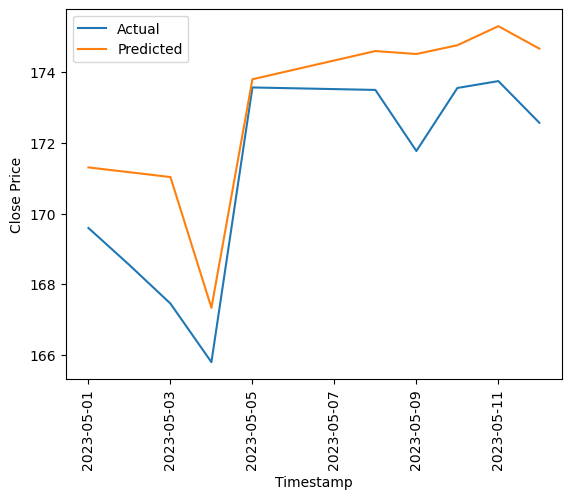

In [66]:
import matplotlib.pyplot as plt

# extract actual and predicted labels from test set
actual_test = predictions2.select("timestamp", "close").collect()
predicted_test = predictions2.select("timestamp", "prediction").collect()



# create lists of timestamps, actual labels, and predicted labels
timestamps_test = [row.timestamp for row in actual_test]
actual_labels_test = [row.close for row in actual_test]
predicted_labels_test = [row.prediction for row in predicted_test]

# plot curve between actual and predicted labels
plt.plot(timestamps_test, actual_labels_test, label="Actual")
plt.plot(timestamps_test, predicted_labels_test, label="Predicted")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.xticks(rotation=90)
plt.legend()
plt.show()